In [3]:
import pandas as pd, numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import pickle

sns.set_palette("deep", desat=0.6)
sns.set_context(rc={"figure.figsize": (8,4)})
import json
from urllib.request import urlopen
import requests
from shapely.geometry import shape, Point

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from datetime import datetime as dt
import time
import folium
from IPython.core.display import HTML

[Please Click here to view this in NBViewer](http://nbviewer.jupyter.org/github/psumank/DATA698/blob/master/Model/pedestrian_incidents_clustering_analysis.ipynb)

PS: for some reason the folium maps are not shown in github. Click the above link to view this page in NBViewer.

## Analyse pedestrian data w.r.to the SLOWZONE vision zero initiative and find *hot spots*

### Find out the *hot spots*  - where SLOWZONE = 1 , and then SLOWZONE=0 

### Load pedestrian incidents where the location is marked for Slow Zone.

In [43]:
#Read the data frame from pickle. Useful when you re-open this session and wanted to directly run this section.
dfpickle = pd.read_pickle('pedestrians.pkl')

filter = (dfpickle["LATITUDE"].notnull()) & (dfpickle["LONGITUDE"].notnull())
dfpickle = dfpickle[filter]

In [44]:
dfpickle['TOTAL_INJURED'] = dfpickle['NUMBER.OF.PERSONS.INJURED'] + dfpickle['NUMBER.OF.PEDESTRIANS.INJURED'] + dfpickle['NUMBER.OF.CYCLIST.INJURED'] + dfpickle['NUMBER.OF.MOTORIST.INJURED']
dfpickle['TOTAL_KILLED'] = dfpickle['NUMBER.OF.PERSONS.KILLED'] + dfpickle['NUMBER.OF.PEDESTRIANS.KILLED'] + dfpickle['NUMBER.OF.CYCLIST.KILLED'] + dfpickle['NUMBER.OF.MOTORIST.KILLED']
dftemp = dfpickle[['LATITUDE', 'LONGITUDE', 'SLOWZONE', 'BOROUGH', 'ZIP.CODE', 'TOTAL_INJURED', 'TOTAL_KILLED', 'year', 'DATENew', 'DAY_OF_WEEK']]
filter = (dftemp["LATITUDE"].notnull()) & (dftemp["LONGITUDE"].notnull())
dftemp = dftemp[filter]
dftemp.to_csv('pedestrian-incidents.csv', encoding='utf-8', index=False)

In [45]:
dfslowzone = dfpickle[dfpickle['SLOWZONE'] == 1]

In [5]:
dfslowzone.head()

,Unnamed: 0,DATE,TIME,BOROUGH,ZIP.CODE,LATITUDE,LONGITUDE,LOCATION,ON.STREET.NAME,CROSS.STREET.NAME,...,VEHICLE.TYPE.CODE.2,VEHICLE.TYPE.CODE.3,VEHICLE.TYPE.CODE.4,VEHICLE.TYPE.CODE.5,DATENew,year,month,DAY_OF_WEEK,hour,SLOWZONE
0,16,02/27/2018,2018-03-24 10:13:00,BROOKLYN,11226.0,40.642690,-73.957640,"(40.64269, -73.95764)",CLARENDON ROAD,FLATBUSH AVENUE,...,NaN,NaN,NaN,NaN,2018-02-27,2018,2,1,10,1
16,248,02/27/2018,2018-03-24 16:40:00,MANHATTAN,10019.0,40.764520,-73.980780,"(40.76452, -73.98078)",NaN,NaN,...,NaN,NaN,NaN,NaN,2018-02-27,2018,2,1,16,1
17,251,02/27/2018,2018-03-24 16:45:00,QUEENS,11432.0,40.705826,-73.793970,"(40.705826, -73.79397)",JAMAICA AVENUE,MERRICK BOULEVARD,...,NaN,NaN,NaN,NaN,2018-02-27,2018,2,1,16,1
26,397,02/27/2018,2018-03-24 22:45:00,QUEENS,11368.0,40.757877,-73.859726,"(40.757877, -73.859726)",NaN,NaN,...,PASSENGER VEHICLE,NaN,NaN,NaN,2018-02-27,2018,2,1,22,1
41,755,02/26/2018,2018-03-24 16:02:00,NaN,NaN,40.675236,-73.971060,"(40.675236, -73.97106)",FLATBUSH AVENUE,PLAZA STREET WEST,...,NaN,NaN,NaN,NaN,2018-02-26,2018,2,0,16,1


In [6]:
dfslowzone.shape

(10500, 36)

In [7]:
dfslowzone.columns

Index(['Unnamed: 0', 'DATE', 'TIME', 'BOROUGH', 'ZIP.CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON.STREET.NAME', 'CROSS.STREET.NAME',
       'OFF.STREET.NAME', 'NUMBER.OF.PERSONS.INJURED',
       'NUMBER.OF.PERSONS.KILLED', 'NUMBER.OF.PEDESTRIANS.INJURED',
       'NUMBER.OF.PEDESTRIANS.KILLED', 'NUMBER.OF.CYCLIST.INJURED',
       'NUMBER.OF.CYCLIST.KILLED', 'NUMBER.OF.MOTORIST.INJURED',
       'NUMBER.OF.MOTORIST.KILLED', 'CONTRIBUTING.FACTOR.VEHICLE.1',
       'CONTRIBUTING.FACTOR.VEHICLE.2', 'CONTRIBUTING.FACTOR.VEHICLE.3',
       'CONTRIBUTING.FACTOR.VEHICLE.4', 'CONTRIBUTING.FACTOR.VEHICLE.5',
       'UNIQUE.KEY', 'VEHICLE.TYPE.CODE.1', 'VEHICLE.TYPE.CODE.2',
       'VEHICLE.TYPE.CODE.3', 'VEHICLE.TYPE.CODE.4', 'VEHICLE.TYPE.CODE.5',
       'DATENew', 'year', 'month', 'DAY_OF_WEEK', 'hour', 'SLOWZONE'],
      dtype='object')

### Identify clusters where SlowZone Marked as 1, but still causing accidents

First define ALL utility functions required

In [7]:
def getcoords(dframe):
    dfgeo1 = dframe.dropna(subset = ['LATITUDE','LONGITUDE'])
    coords = dfgeo1.as_matrix(columns=['LATITUDE','LONGITUDE'])
    return coords

In [8]:
# define epsilon as 0.5 kilometers, converted to radians for use by haversine
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian
min_sample=50
epsilon

7.848050688613081e-05

In [9]:
def applyDBSCAN(coordinates, epsilon, min_samples):
    start_time = time.time()
    db = DBSCAN(eps=epsilon, min_samples = min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))
    cluster_labels = db.labels_
    # get the number of clusters
    num_clusters = len(set(cluster_labels))
    print(num_clusters)
    clusters = pd.Series([coordinates[cluster_labels==n] for n in range(num_clusters)])
    message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
    print(message.format(len(coordinates), num_clusters, 100*(1 - float(num_clusters) / len(coordinates)), time.time()-start_time))
    return clusters

In [10]:
def get_centermost_point(clusters):
    centroid = (MultiPoint(clusters).centroid.x, MultiPoint(clusters).centroid.y)
    centermost_point = min(clusters, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [11]:
#Find the point in each cluster that is closest to its centroid
def gethotspots(clusters, df):
    centermost_points = []
    for cluster in clusters.iteritems():
        if len(cluster[1]) >= min_sample:
            centermost_points.append(get_centermost_point(cluster[1]))
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    # that way we get the full details from the original dataframe
    rs = rep_points.apply(lambda row: df[(df['LATITUDE']==row['lat']) & 
                                             (df['LONGITUDE']==row['lon'])].iloc[0], axis=1)
    return rs

In [12]:
def plotHotSpots(orgdf, rset):
    # plot the final reduced set of coordinate points vs the original full set
    fig, ax = plt.subplots(figsize=[17.5, 17])
    df_scatter1 = ax.scatter(orgdf['LONGITUDE'], orgdf['LATITUDE'], c='k', alpha=0.9, s=3)
    rs_scatter1 = ax.scatter(rset['LONGITUDE'], rset['LATITUDE'], c='#FF8C00', edgecolor='None', alpha=0.7, s=120)
    ax.set_title('Full data set vs DBSCAN reduced set')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-74.06, -73.77)
    ax.set_ylim(40.61, 40.91)
    ax.legend([df_scatter1, rs_scatter1], ['Full set', 'Reduced set'], loc='upper right')
    plt.show()

In [13]:
def buildFoliumMap(rs):
    NY_COORDINATES = (40.61, -74.06)
    # create empty map zoomed in on NYC
    map = folium.Map(location=NY_COORDINATES, zoom_start=11)
    
    for each in rs.iterrows():
        folium.CircleMarker(
            location = [each[1]['LATITUDE'],each[1]['LONGITUDE']],
            radius = 12, popup= str(each[1]['BOROUGH']) + ": " + str(each[1]["ON.STREET.NAME"]) + "(zip:" + str(each[1]["ZIP.CODE"]) + ")",
        fill=True, color='#3186cc', fill_color='#FF8C00', fill_opacity=0.7).add_to(map)
    return map

In [14]:
def plotHotSpots_Folium(rs):
    display(buildFoliumMap(rs))

In [46]:
coords = getcoords(dfslowzone)

In [11]:
coords

array([[ 40.64269  , -73.95764  ],
       [ 40.76452  , -73.98078  ],
       [ 40.705826 , -73.79397  ],
       ...,
       [ 40.6396243, -73.9547692],
       [ 40.8315678, -73.9429813],
       [ 40.7466595, -73.9900681]])

In [14]:
clusters = applyDBSCAN(coords, epsilon, min_sample)

27
Clustered 10,500 points down to 27 clusters, for 99.7% compression in 0.50 seconds


In [17]:
rs = gethotspots(clusters, dfslowzone)
#taking 6 digit of latitude and longitude after decimal point
rs.to_csv('testgeneral.csv', float_format='%.6f', encoding='utf-8')

In [18]:
rs.columns

Index(['Unnamed: 0', 'DATE', 'TIME', 'BOROUGH', 'ZIP.CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON.STREET.NAME', 'CROSS.STREET.NAME',
       'OFF.STREET.NAME', 'NUMBER.OF.PERSONS.INJURED',
       'NUMBER.OF.PERSONS.KILLED', 'NUMBER.OF.PEDESTRIANS.INJURED',
       'NUMBER.OF.PEDESTRIANS.KILLED', 'NUMBER.OF.CYCLIST.INJURED',
       'NUMBER.OF.CYCLIST.KILLED', 'NUMBER.OF.MOTORIST.INJURED',
       'NUMBER.OF.MOTORIST.KILLED', 'CONTRIBUTING.FACTOR.VEHICLE.1',
       'CONTRIBUTING.FACTOR.VEHICLE.2', 'CONTRIBUTING.FACTOR.VEHICLE.3',
       'CONTRIBUTING.FACTOR.VEHICLE.4', 'CONTRIBUTING.FACTOR.VEHICLE.5',
       'UNIQUE.KEY', 'VEHICLE.TYPE.CODE.1', 'VEHICLE.TYPE.CODE.2',
       'VEHICLE.TYPE.CODE.3', 'VEHICLE.TYPE.CODE.4', 'VEHICLE.TYPE.CODE.5',
       'DATENew', 'year', 'month', 'DAY_OF_WEEK', 'hour', 'SLOWZONE'],
      dtype='object')

### Hot Spots - Currently SlowZone Areas

In [19]:
rs[['LOCATION','BOROUGH','ON.STREET.NAME', 'CROSS.STREET.NAME']].sort_values('BOROUGH')

,LOCATION,BOROUGH,ON.STREET.NAME,CROSS.STREET.NAME
11,"(40.81702, -73.92799)",BRONX,NaN,NaN
23,"(40.85071, -73.89408)",BRONX,EAST 180 STREET,3 AVENUE
3,"(40.859303, -73.89884)",BRONX,EAST 184 STREET,GRAND CONCOURSE
12,"(40.83501, -73.90353)",BRONX,3 AVENUE,EAST 170 STREET
24,"(40.84416, -73.8854)",BRONX,NaN,NaN
10,"(40.820984, -73.891624)",BRONX,SOUTHERN BOULEVARD,EAST 163 STREET
22,"(40.5804841, -73.9598312)",BROOKLYN,CONEY ISLAND AVENUE,BRIGHTON 10 LANE
21,"(40.5901817, -73.9605707)",BROOKLYN,CONEY ISLAND AVENUE,DUNNE COURT
15,"(40.6152042, -73.9633618)",BROOKLYN,CONEY ISLAND AVENUE,AVENUE N
14,"(40.6307903, -73.9455126)",BROOKLYN,FLATBUSH AVENUE,EAST 32 STREET


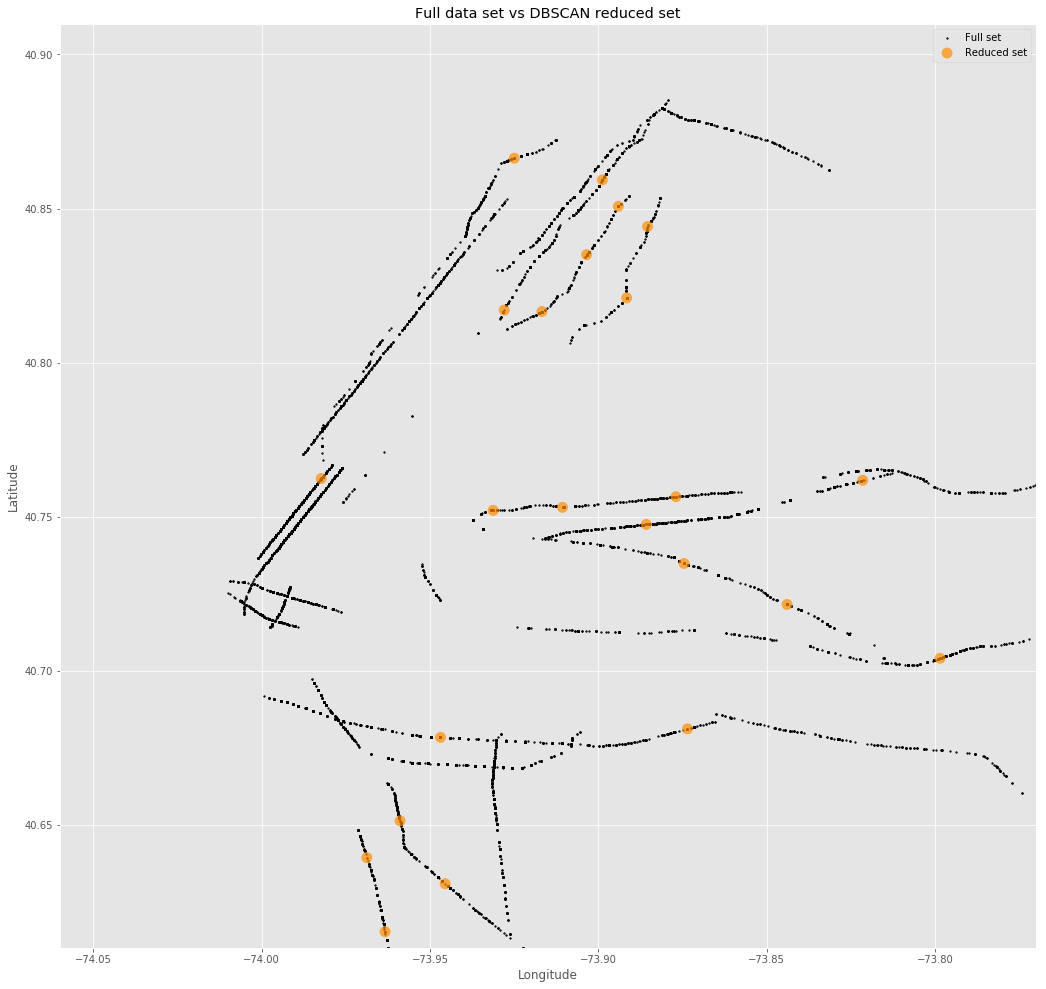

In [21]:
plotHotSpots(dfslowzone, rs)

In [22]:
rs.columns

Index(['Unnamed: 0', 'DATE', 'TIME', 'BOROUGH', 'ZIP.CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON.STREET.NAME', 'CROSS.STREET.NAME',
       'OFF.STREET.NAME', 'NUMBER.OF.PERSONS.INJURED',
       'NUMBER.OF.PERSONS.KILLED', 'NUMBER.OF.PEDESTRIANS.INJURED',
       'NUMBER.OF.PEDESTRIANS.KILLED', 'NUMBER.OF.CYCLIST.INJURED',
       'NUMBER.OF.CYCLIST.KILLED', 'NUMBER.OF.MOTORIST.INJURED',
       'NUMBER.OF.MOTORIST.KILLED', 'CONTRIBUTING.FACTOR.VEHICLE.1',
       'CONTRIBUTING.FACTOR.VEHICLE.2', 'CONTRIBUTING.FACTOR.VEHICLE.3',
       'CONTRIBUTING.FACTOR.VEHICLE.4', 'CONTRIBUTING.FACTOR.VEHICLE.5',
       'UNIQUE.KEY', 'VEHICLE.TYPE.CODE.1', 'VEHICLE.TYPE.CODE.2',
       'VEHICLE.TYPE.CODE.3', 'VEHICLE.TYPE.CODE.4', 'VEHICLE.TYPE.CODE.5',
       'DATENew', 'year', 'month', 'DAY_OF_WEEK', 'hour', 'SLOWZONE'],
      dtype='object')

In [23]:
rstemp_sz = rs[['LATITUDE', 'LONGITUDE', 'SLOWZONE', 'BOROUGH', 'ZIP.CODE', 'ON.STREET.NAME','CROSS.STREET.NAME']]
rstemp_sz.to_csv('pedestrian-hotspots-slowzone-1.csv', encoding='utf-8', index=False)

In [26]:
plotHotSpots_Folium(rs)

#### Render as HTML iFrame

In [27]:
def inline(m, height=600):
    """Takes a folium instance and embed HTML."""
    srcdoc = m.get_root().render().replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{0}" '
                 'style="width: 100%; height: {1}px; '
                 'border: none"></iframe>'.format(srcdoc, height))
    return embed

### Lets looks for HotSpots in *non slowzone* areas 

In [29]:
dfpickle = pd.read_pickle('pedestrians.pkl')
dfnonslowzone = dfpickle[dfpickle['SLOWZONE'] == 0]
dfnonslowzone = dfnonslowzone.dropna(subset = ['LATITUDE','LONGITUDE', 'ON.STREET.NAME'])

In [30]:
dfpickle.shape


(85037, 36)

In [31]:
dfnonslowzone.shape

(58745, 36)

In [32]:
coords_nonslowzone = getcoords(dfnonslowzone)

In [33]:
coords_nonslowzone

array([[ 40.8475   , -73.86696  ],
       [ 40.645027 , -73.91998  ],
       [ 40.83511  , -73.91945  ],
       ...,
       [ 40.8626793, -73.9090397],
       [ 40.6945453, -73.802112 ],
       [ 40.7578587, -73.975592 ]])

In [34]:
len(coords_nonslowzone)

58745

In [35]:
epsilon = 0.5 / kms_per_radian
min_sample=50
print(epsilon)
print(min_sample)
clusters_nonslowzone = applyDBSCAN(coords_nonslowzone, epsilon, min_sample)
print(clusters_nonslowzone)

7.848050688613081e-05
50
28
Clustered 58,745 points down to 28 clusters, for 100.0% compression in 7.00 seconds
0     [[40.8475, -73.86695999999999], [40.83511, -73...
1     [[40.645027, -73.91998000000001], [40.67042999...
2     [[40.753997999999996, -73.94244], [40.761692, ...
3     [[40.681778, -73.78156], [40.671825, -73.77450...
4     [[40.755524, -73.833405], [40.743538, -73.8337...
5     [[40.602191999999995, -73.75523000000001], [40...
6     [[40.71991, -73.809044], [40.718445, -73.80862...
7     [[40.7331, -73.80499], [40.726684999999996, -7...
8     [[40.87147, -73.83057], [40.870396, -73.8259],...
9     [[40.718887, -73.76446999999999], [40.725143, ...
10    [[40.624195, -74.07816], [40.61293, -74.087493...
11    [[40.730194, -73.887566], [40.731968, -73.8847...
12    [[40.830723, -73.82321999999999], [40.822548, ...
13    [[40.673588, -73.73351], [40.664745, -73.74003...
14    [[40.676693, -73.74221], [40.677085999999996, ...
15    [[40.700005, -73.7547], [40.69482999999999

In [36]:
rsnsz = gethotspots(clusters_nonslowzone, dfnonslowzone)

### Hot Spots - Currently where there is no SlowZone initiative 

In [37]:
rsnsz[['LOCATION','BOROUGH','ON.STREET.NAME', 'CROSS.STREET.NAME']].sort_values('BOROUGH')

,LOCATION,BOROUGH,ON.STREET.NAME,CROSS.STREET.NAME
11,"(40.8267983, -73.8223616)",BRONX,EAST TREMONT AVENUE,DILL PLACE
8,"(40.869118, -73.83048)",BRONX,BARTOW AVENUE,ASCH LOOP
1,"(40.6614962, -73.9398863)",BROOKLYN,ALBANY AVENUE,MAPLE STREET
0,"(40.79157, -73.94469)",MANHATTAN,EAST 106 STREET,3 AVENUE
4,"(40.75784, -73.8244478)",QUEENS,,
23,"(40.592963, -73.794171)",QUEENS,BEACH 65 STREET,BEACH CHANNEL DRIVE
21,"(40.7832257, -73.8431254)",QUEENS,125 STREET,18 AVENUE
19,"(40.6654959, -73.7557205)",QUEENS,SOUTH CONDUIT AVENUE,222 STREET
17,"(40.680202, -73.754105)",QUEENS,MERRICK BOULEVARD,RIDGEDALE STREET
16,"(40.71204, -73.73646)",QUEENS,HOLLIS AVENUE,SPRINGFIELD BOULEVARD


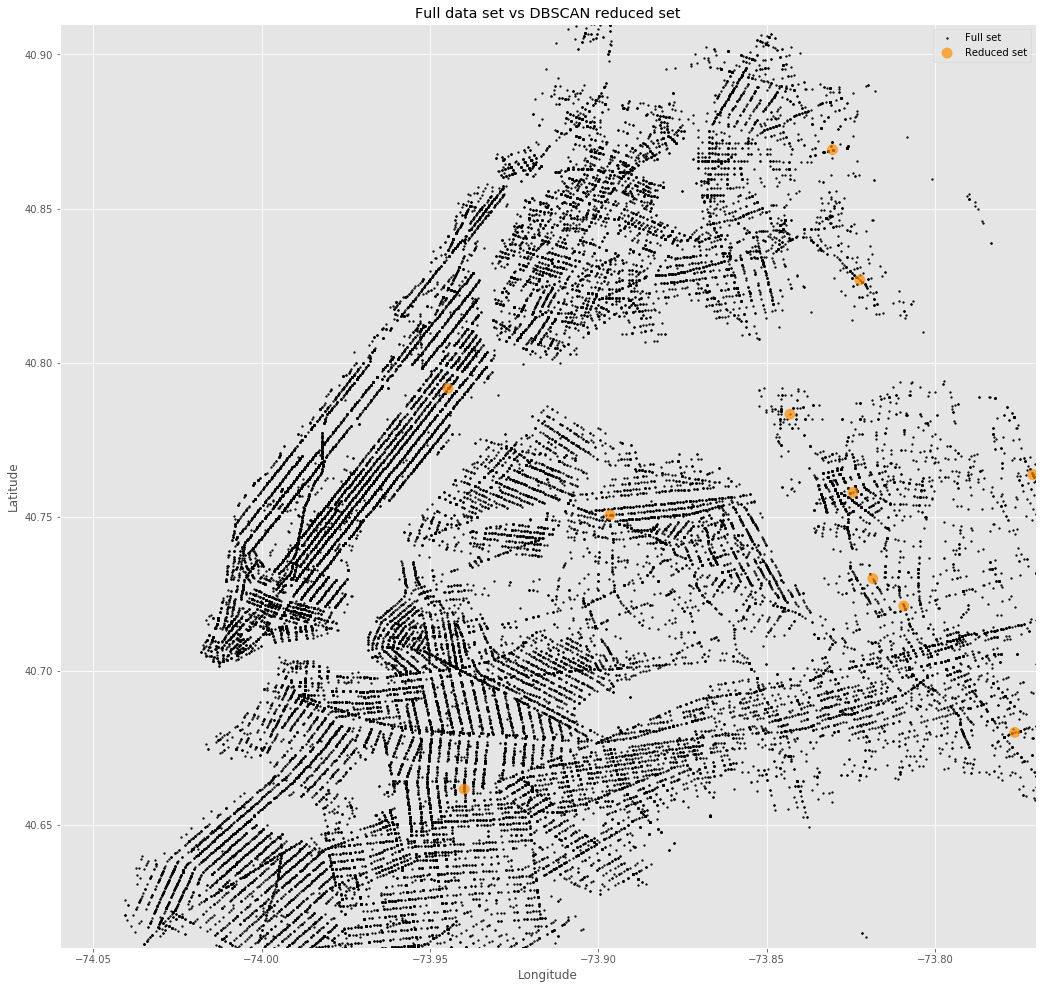

In [38]:
plotHotSpots(dfnonslowzone, rsnsz)

In [39]:
rstemp_nsz = rsnsz[['LATITUDE', 'LONGITUDE', 'SLOWZONE', 'BOROUGH', 'ZIP.CODE', 'ON.STREET.NAME','CROSS.STREET.NAME']]
rstemp_nsz.to_csv('pedestrian-hotspots-slowzone-0.csv', encoding='utf-8', index=False)

In [40]:
#combine all hot spots
hotsplots = rstemp_sz.append(rstemp_nsz)
hotsplots.to_csv('pedestrian-hotspots-slowzone.csv', encoding='utf-8', index=False)

Review the hot spots above and install speed zones

In [41]:
plotHotSpots_Folium(rsnsz)

# Speed Humps

In [3]:
dfpred_speedhumps = pd.read_pickle('pedestrians_speedhumps.pkl')

In [7]:
dfpred_speedhumps.head()

,Unnamed: 0,DATE,TIME,BOROUGH,ZIP.CODE,LATITUDE,LONGITUDE,LOCATION,ON.STREET.NAME,CROSS.STREET.NAME,...,VEHICLE.TYPE.CODE.3,VEHICLE.TYPE.CODE.4,VEHICLE.TYPE.CODE.5,DATENew,year,month,DAY_OF_WEEK,hour,SLOWZONE,SPEEDHUMP
0,16,02/27/2018,2018-03-24 10:13:00,BROOKLYN,11226.0,40.642690,-73.95764,"(40.64269, -73.95764)",CLARENDON ROAD,FLATBUSH AVENUE,...,NaN,NaN,NaN,2018-02-27,2018,2,1,10,1,0
1,42,02/27/2018,2018-03-24 10:56:00,NaN,NaN,40.847500,-73.86696,"(40.8475, -73.86696)",RHINELANDER AVENUE,WHITE PLAINS ROAD,...,NaN,NaN,NaN,2018-02-27,2018,2,1,10,0,0
2,50,02/27/2018,2018-03-24 11:08:00,QUEENS,11432.0,40.705200,-73.79926,"(40.7052, -73.79926)",NaN,NaN,...,NaN,NaN,NaN,2018-02-27,2018,2,1,11,0,1
3,57,02/27/2018,2018-03-24 11:30:00,BROOKLYN,11201.0,40.695232,-73.98326,"(40.695232, -73.98326)",NaN,NaN,...,NaN,NaN,NaN,2018-02-27,2018,2,1,11,0,0
4,71,02/27/2018,2018-03-24 12:03:00,BROOKLYN,11236.0,40.645027,-73.91998,"(40.645027, -73.91998)",CLARENDON ROAD,RALPH AVENUE,...,NaN,NaN,NaN,2018-02-27,2018,2,1,12,0,0


In [6]:
#lets reanme to SPEEDHUMP
dfpred_speedhumps.rename(columns={'SPEED_BUMP': 'SPEEDHUMP'}, inplace=True)

In [8]:
dfpred_speedhumps.shape

(85037, 37)

Save the pedestrian-incidents.csv with SPEEDHUMP column and other key columns [ for shiny app , this is used later on]

In [11]:
dfpred_speedhumps['TOTAL_INJURED'] = dfpred_speedhumps['NUMBER.OF.PERSONS.INJURED'] + dfpred_speedhumps['NUMBER.OF.PEDESTRIANS.INJURED'] + dfpred_speedhumps['NUMBER.OF.CYCLIST.INJURED'] + dfpred_speedhumps['NUMBER.OF.MOTORIST.INJURED']
dfpred_speedhumps['TOTAL_KILLED'] = dfpred_speedhumps['NUMBER.OF.PERSONS.KILLED'] + dfpred_speedhumps['NUMBER.OF.PEDESTRIANS.KILLED'] + dfpred_speedhumps['NUMBER.OF.CYCLIST.KILLED'] + dfpred_speedhumps['NUMBER.OF.MOTORIST.KILLED']
filter = (dfpred_speedhumps["LATITUDE"].notnull()) & (dfpred_speedhumps["LONGITUDE"].notnull())
dfpred_speedhumps = dfpred_speedhumps[filter]
dftemp = dfpred_speedhumps[['LATITUDE', 'LONGITUDE', 'SLOWZONE', 'SPEEDHUMP','BOROUGH', 'ZIP.CODE', 'TOTAL_INJURED', 'TOTAL_KILLED', 'year', 'DATENew', 'DAY_OF_WEEK']]
dftemp.to_csv('pedestrian-incidents.csv', encoding='utf-8', index=False)

Lets now cluster the hot spots for both SPEED HUMPS and non speed humps

In [28]:
dfspeedhump = dfpred_speedhumps[dfpred_speedhumps['SPEEDHUMP'] == 1]
dfnonspeedhump = dfpred_speedhumps[dfpred_speedhumps['SPEEDHUMP'] == 0]

In [29]:
dfspeedhump.shape
dfnonspeedhump.shape

(63777, 39)

## Hot spots in speed hump enabled locations 

In [27]:
coords = getcoords(dfspeedhump)
clusters = applyDBSCAN(coords, epsilon, min_sample)
rs = gethotspots(clusters, dfspeedhump)
rstemp_sh = rs[['LATITUDE', 'LONGITUDE', 'SLOWZONE', 'SPEEDHUMP', 'BOROUGH', 'ZIP.CODE', 'ON.STREET.NAME','CROSS.STREET.NAME']]
plotHotSpots_Folium(rstemp_sh )

28
Clustered 9,657 points down to 28 clusters, for 99.7% compression in 0.51 seconds


## Hot spots in NON speed hump  locations 

In [31]:
coords = getcoords(dfnonspeedhump)
clusters = applyDBSCAN(coords, epsilon, min_sample)
rs = gethotspots(clusters, dfnonspeedhump)
rstemp_non_sh = rs[['LATITUDE', 'LONGITUDE', 'SLOWZONE', 'SPEEDHUMP', 'BOROUGH', 'ZIP.CODE', 'ON.STREET.NAME','CROSS.STREET.NAME']]
plotHotSpots_Folium(rstemp_non_sh )

31
Clustered 63,777 points down to 31 clusters, for 100.0% compression in 5.16 seconds


### COMBINE ALL HOT-SPOTS WE GATHERED SO FAR INTO ONE

In [37]:
#existing hot-spots
hotspots = pd.read_csv('pedestrian-hotspots-slowzone.csv')
hotspots.head()

,LATITUDE,LONGITUDE,SLOWZONE,BOROUGH,ZIP.CODE,ON.STREET.NAME,CROSS.STREET.NAME
0,40.651212,-73.958924,1,BROOKLYN,11226.0,MARTENSE STREET,FLATBUSH AVENUE
1,40.762342,-73.982352,1,MANHATTAN,10019.0,7 AVENUE,WEST 52 STREET
2,40.703989,-73.798546,1,QUEENS,11432.0,JAMAICA AVENUE,161 STREET
3,40.859303,-73.898840,1,BRONX,10468.0,EAST 184 STREET,GRAND CONCOURSE
4,40.747441,-73.885789,1,QUEENS,11372.0,ROOSEVELT AVENUE,80 STREET


In [39]:
#Add a column for SPEEDHUMP
hotspots['SPEEDHUMP'] =np.nan

In [41]:
#combine all hot spots
combined_sh_hotspots = rstemp_sh.append(rstemp_non_sh)

#combine with prev hotspots
hotspots = hotspots.append(combined_sh_hotspots)
hotspots.to_csv('pedestrian-hotspots-slowzone-speedhump.csv', encoding='utf-8', index=False)

# Lets load the entire data set with vision zero values and find clusters 

In [4]:
df_fulldata = pd.read_pickle('full_pedestrian_data_with_visionzero.pkl')

In [5]:
df_fulldata.head()

,Unnamed: 0,DATE,TIME,BOROUGH,ZIP.CODE,LATITUDE,LONGITUDE,LOCATION,ON.STREET.NAME,CROSS.STREET.NAME,...,LEADING_PEDESTRIAN_INTERVAL,LEFT_TURN_TRAFFIC_CALMING,NEIGHBORHOOD_SLOW_ZONE,SAFE_STREETS_FOR_SENIORS,SIP_INTERSECTIONS,SIP_CORRIDORS,PRIORITY_CORRIDORS,PRIORITY_INTERSECTIONS,PRIORITY_ZONES,NBR_VZ_INITIATIVES
0,16,02/27/2018,2018-03-24 10:13:00,BROOKLYN,11226.0,40.642690,-73.95764,"(40.64269, -73.95764)",CLARENDON ROAD,FLATBUSH AVENUE,...,0,0,0,1,0,0,1,0,1,6
1,42,02/27/2018,2018-03-24 10:56:00,NaN,NaN,40.847500,-73.86696,"(40.8475, -73.86696)",RHINELANDER AVENUE,WHITE PLAINS ROAD,...,0,0,0,0,0,1,1,0,0,3
2,50,02/27/2018,2018-03-24 11:08:00,QUEENS,11432.0,40.705200,-73.79926,"(40.7052, -73.79926)",NaN,NaN,...,0,0,0,0,0,0,0,0,1,2
3,57,02/27/2018,2018-03-24 11:30:00,BROOKLYN,11201.0,40.695232,-73.98326,"(40.695232, -73.98326)",NaN,NaN,...,0,0,0,0,0,0,0,0,1,1
4,71,02/27/2018,2018-03-24 12:03:00,BROOKLYN,11236.0,40.645027,-73.91998,"(40.645027, -73.91998)",CLARENDON ROAD,RALPH AVENUE,...,0,0,0,1,1,1,1,0,0,6


In [6]:
df_fulldata['TOTAL_INJURED'] = df_fulldata['NUMBER.OF.PERSONS.INJURED'] + df_fulldata['NUMBER.OF.PEDESTRIANS.INJURED'] + df_fulldata['NUMBER.OF.CYCLIST.INJURED'] + df_fulldata['NUMBER.OF.MOTORIST.INJURED']
df_fulldata['TOTAL_KILLED'] = df_fulldata['NUMBER.OF.PERSONS.KILLED'] + df_fulldata['NUMBER.OF.PEDESTRIANS.KILLED'] + df_fulldata['NUMBER.OF.CYCLIST.KILLED'] + df_fulldata['NUMBER.OF.MOTORIST.KILLED']
#dftemp = dfpickle[['LATITUDE', 'LONGITUDE', 'SLOWZONE', 'BOROUGH', 'ZIP.CODE', 'TOTAL_INJURED', 'TOTAL_KILLED', 'year', 'DATENew', 'DAY_OF_WEEK']]
filter = (df_fulldata["LATITUDE"].notnull()) & (df_fulldata["LONGITUDE"].notnull())
df_fulldata = df_fulldata[filter]
df_fulldata.to_csv('pedestrian-incidents-fulldata.csv', encoding='utf-8', index=False)

In [18]:
epsilon = 0.5 / kms_per_radian
min_sample=50
coords = getcoords(df_fulldata)
clusters = applyDBSCAN(coords, epsilon, min_sample)
rs = gethotspots(clusters, df_fulldata)
plotHotSpots_Folium(rs )

27
Clustered 73,434 points down to 27 clusters, for 100.0% compression in 13.13 seconds


In [19]:
#Store the hotspots into a file
#rs['EPSILON'] = 0.5
#rs.to_csv('pedestrian-hotspots-fulldata-epsilon-0_5.csv', encoding='utf-8', index=False)

In [54]:
def prepareHotSpotsForFullData(df_fulldata):
    rs = pd.DataFrame()
    for min_sample in range(10, 110, 10):
        for i in range(0, 11, 1):
            if i != 0:
                tmp = i / 10.0
                epsilon = tmp / kms_per_radian
                clusters = applyDBSCAN(coords, epsilon, min_sample)
                hsdata = gethotspots(clusters, df_fulldata)
                hsdata['EPSILON'] = tmp
                hsdata['SAMPLES'] = min_sample
                rs = rs.append(hsdata)
    return rs


In [55]:
rs = prepareHotSpotsForFullData(df_fulldata)

1357
Clustered 73,434 points down to 1,357 clusters, for 98.2% compression in 8.27 seconds
267
Clustered 73,434 points down to 267 clusters, for 99.6% compression in 4.95 seconds
79
Clustered 73,434 points down to 79 clusters, for 99.9% compression in 6.09 seconds
39
Clustered 73,434 points down to 39 clusters, for 99.9% compression in 7.25 seconds
20
Clustered 73,434 points down to 20 clusters, for 100.0% compression in 7.22 seconds
13
Clustered 73,434 points down to 13 clusters, for 100.0% compression in 9.14 seconds
12
Clustered 73,434 points down to 12 clusters, for 100.0% compression in 9.97 seconds
11
Clustered 73,434 points down to 11 clusters, for 100.0% compression in 10.49 seconds
7
Clustered 73,434 points down to 7 clusters, for 100.0% compression in 11.96 seconds
6
Clustered 73,434 points down to 6 clusters, for 100.0% compression in 13.67 seconds
670
Clustered 73,434 points down to 670 clusters, for 99.1% compression in 3.81 seconds
240
Clustered 73,434 points down to 240 

13
Clustered 73,434 points down to 13 clusters, for 100.0% compression in 8.59 seconds
13
Clustered 73,434 points down to 13 clusters, for 100.0% compression in 10.03 seconds
9
Clustered 73,434 points down to 9 clusters, for 100.0% compression in 11.46 seconds
7
Clustered 73,434 points down to 7 clusters, for 100.0% compression in 12.66 seconds
6
Clustered 73,434 points down to 6 clusters, for 100.0% compression in 13.69 seconds


In [57]:
rs.shape

(2806, 54)

In [59]:
rs.tail()

,Unnamed: 0,DATE,TIME,BOROUGH,ZIP.CODE,LATITUDE,LONGITUDE,LOCATION,ON.STREET.NAME,CROSS.STREET.NAME,...,SIP_INTERSECTIONS,SIP_CORRIDORS,PRIORITY_CORRIDORS,PRIORITY_INTERSECTIONS,PRIORITY_ZONES,NBR_VZ_INITIATIVES,TOTAL_INJURED,TOTAL_KILLED,EPSILON,SAMPLES
0,958720,10/14/2013,2018-03-24 20:50:00,NaN,NaN,40.728950,-73.927923,"(40.72895, -73.9279233)",NaN,NaN,...,0,0,0,0,0,0,2,0,1.0,100
1,4551,02/19/2018,2018-03-24 09:00:00,QUEENS,11691.0,40.602192,-73.755230,"(40.602192, -73.75523)",CORNAGA AVENUE,BEACH 22 STREET,...,0,0,0,0,0,0,2,0,1.0,100
2,155188,06/23/2017,2018-03-24 18:42:00,STATEN ISLAND,10304.0,40.626007,-74.082350,"(40.626007, -74.08235)",NaN,NaN,...,0,0,0,0,1,1,2,0,1.0,100
3,1159454,10/14/2012,2018-03-24 15:20:00,STATEN ISLAND,10306.0,40.577100,-74.104960,"(40.5771, -74.1049599)",LINCOLN AVENUE,GRANT PLACE,...,0,0,0,0,1,1,2,0,1.0,100
4,793738,08/02/2014,2018-03-24 17:12:00,STATEN ISLAND,10310.0,40.631729,-74.124893,"(40.631729, -74.1248934)",CARY AVENUE,CLOVE ROAD,...,0,1,1,0,1,5,4,0,1.0,100


In [60]:
rs.to_csv('pedestrian-hotspots-fulldata.csv', encoding='utf-8', index=False)